# Creating a model of SERCA

Here we will create a bond graph model of a more complicated system - the model of SERCA described in Tran et al. (2009), which was later represented as a bond graph in Pan et al. (2018). The reaction scheme for the network is shown below.

![](Tran_SERCA.svg)

To create this model, we make lists of the reactions and chemostats.

In [1]:
from BondGraphTools import reaction_builder
from BondGraphTools.reaction_builder import Reaction_Network

from BondGraphTools import draw, simulate
from numpy import log
import matplotlib.pyplot as plt
from sympy import init_printing, SparseMatrix, Eq, Symbol, lambdify
init_printing()

reactions = [
    ("P1 + MgATP = P2", 'R1,2'),
    ("P2 + H = P2a", 'R2,2a'),
    ("P2 + 2*Cai = P4", 'R2,4'),
    ("P4 = P5 + 2*H", 'R4,5'),
    ("P5 = P6 + MgADP", 'R5,6'),
    ("P6 = P8 + 2*Casr", 'R6,8'),
    ("P8 + 2*H = P9", 'R8,9'),
    ("P9 = P10 + H", 'R9,10'),
    ("P10 = P1 + Pi", 'R10,1')
]

metabolites = ['MgATP', 'MgADP', 'Pi', 'H', 'Cai', 'Casr']

We can then use for loops to sequentially add the reactions and chemostats to the model using the Reaction Builder.

In [2]:
# Create a new reaction network
rn_SERCA = Reaction_Network(name="SERCA Network")

# Add reactions to the reaction network
for reaction, Re_name in reactions:
    rn_SERCA.add_reaction(reaction=reaction, name=Re_name)

# Add chemostats to the reaction network
for metabolite in metabolites:
    rn_SERCA.add_chemostat(metabolite)
    
# Print the species and reactions
print('Species:')
print(rn_SERCA.species)
print('\n')
print('Reactions:')
for reaction in rn_SERCA._reactions.keys():
    print(reaction, rn_SERCA._reactions[reaction])

Species:
['P1', 'MgATP', 'P2', 'H', 'P2a', 'Cai', 'P4', 'P5', 'P6', 'MgADP', 'P8', 'Casr', 'P9', 'P10', 'Pi']


Reactions:
R1,2 ({'P1': 1, 'MgATP': 1}, {'P2': 1}, None, None)
R2,2a ({'P2': 1, 'H': 1}, {'P2a': 1}, None, None)
R2,4 ({'P2': 1, 'Cai': 2}, {'P4': 1}, None, None)
R4,5 ({'P4': 1}, {'P5': 1, 'H': 2}, None, None)
R5,6 ({'P5': 1}, {'P6': 1, 'MgADP': 1}, None, None)
R6,8 ({'P6': 1}, {'P8': 1, 'Casr': 2}, None, None)
R8,9 ({'P8': 1, 'H': 2}, {'P9': 1}, None, None)
R9,10 ({'P9': 1}, {'P10': 1, 'H': 1}, None, None)
R10,1 ({'P10': 1}, {'P1': 1, 'Pi': 1}, None, None)


We then convert the reaction network into a bond graph, and draw the bond graph.

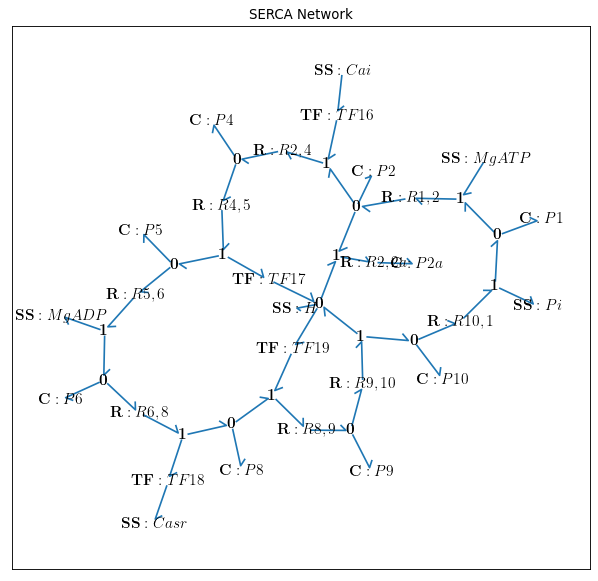

In [3]:
model = rn_SERCA.as_network_model(normalised=True)
draw(model)

We can also derive the differential equations for the model.

In [4]:
model.constitutive_relations

The parameters for the model have not been set. We can define these parameters using a list and use a for loop to set these parameters.

In [5]:
reaction_rates = {
    "R1,2": 0.00053004, 
    "R2,2a": 8326784.0537,
    "R2,4": 1567.7476,
    "R4,5": 1567.7476,
    "R5,6": 3063.4006,
    "R6,8": 130852.3839,
    "R8,9": 11612934.8748,
    "R9,10": 11612934.8748,
    "R10,1": 0.049926
}

species_affinities = {"P1": 5263.6085,
                   "P2": 3803.6518,
                   "P2a": 3110.4445,
                   "P4": 16520516.1239,
                   "P5": 0.82914,
                   "P6": 993148.433,
                   "P8": 37.7379,
                   "P9": 2230.2717,
                   "P10": 410.6048,
                   "Cai": 1.9058,
                   "Casr": 31.764,
                   "MgATP": 244.3021,
                   "MgADP": 5.8126e-7,
                   "Pi": 0.014921,
                   "H": 1862.5406}

R = reaction_builder.R
T = 310

# Set reaction rate constants
for reaction,rate in reaction_rates.items():
    comp = model/f"R:{reaction}"
    comp.set_param('r',rate)
    comp.set_param('R',R)
    comp.set_param('T',T)

# Set species constants
for species,affinity in species_affinities.items():
    if species not in metabolites:
        comp = model/f"C:{species}"
        comp.set_param('k',affinity)
        comp.set_param('R',R)
        comp.set_param('T',T)

We can also set the efforts of the chemostats automatically using a function.

In [6]:
# Define the fixed amounts for each chemostat
chemostat_amounts = {
    "Cai": 0.0057,
    "Casr": None,
    "H": 0.004028,
    "MgADP": 1.3794,
    "MgATP": 3.8,
    "Pi": 570
}

for species in metabolites:
    affinity = species_affinities[species]
    comp = model/f"SS:{species}"
    if chemostat_amounts[species]:
        effort = R*T*log(species_affinities[species]*chemostat_amounts[species])
        comp.set_param('e',effort)

We check the parameters have been set by deriving the differential equation again.

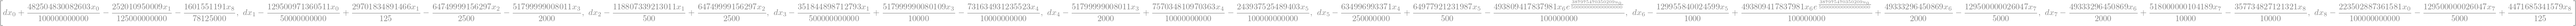

In [7]:
model.constitutive_relations

We will next simulate this model. We first set the initial conditions of the model.

In [8]:
# Initial Conditions
initial_conditions = {
    "P1": 0.000483061870385487,
    "P2": 0.0574915174273067,
    "P2a": 0.527445119834607,
    "P4": 1.51818391164022e-09,
    "P5": 0.000521923287622898,
    "P6": 7.80721128535043e-05,
    "P8": 0.156693953834181,
    "P9": 0.149232225342376,
    "P10": 0.108044124948978
}

def simulation_ic(model,initial_conditions):
    num_states = len(model.state_vars)
    array_initial_conditions = [0]*num_states
    state_order = [[]]*num_states
    for i in range(num_states):
        comp = model.state_vars['x_'+str(i)][0]
        array_initial_conditions[i] = initial_conditions[comp.name]
        state_order[i] = comp.name
    return array_initial_conditions, state_order

array_initial_conditions, state_order = simulation_ic(model,initial_conditions)
array_initial_conditions

We finally simulate and plot the model. The amount of SR calcium was left as a control variable, and we allow it to gradually increase over time, according to the function $[\mathrm{ Ca_{sr}^{2+}}] = 0.05+0.01t$.

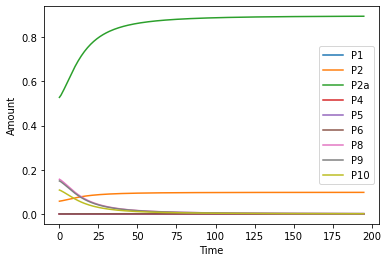

In [9]:
vol_sr = 2.28
K_Casr = species_affinities['Casr']

t,x = simulate(model, timespan = (0.0,195.0), x0 = array_initial_conditions, dt=1, 
                   control_vars={'u_0':f'{R}*{T}*log({K_Casr}*(0.05+0.01*t)*{vol_sr})'})
plt.plot(t,x)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend(state_order)

Using the functions defined in the previous notebook, we can also find the flux through R1,2 to calculate the cycling rate of the pump, which we plot against SR calcium concentration.

Text(0, 0.5, 'Cycling rate')

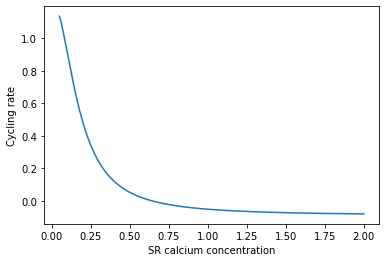

In [10]:
def full_equations(model):
    # Load full equations of model
    X, mapping, A, F, G = model.system_model()
    # AX + F(X) = 0
    # G(X) = 0
    AX = A*SparseMatrix(X) + F
    full_model_equations = {}
    for i in range(AX.rows):
        xi = X[i]
        eqn = xi - AX[i,0]
        full_model_equations[str(xi)] = eqn
    return full_model_equations

# Define a function that returns the port for a component
def find_port(component,direction):
    if direction in ['f', 'forward']:
        index = 0
    elif direction in ['r', 'reverse']:
        index = 1
    return list(component.ports.keys())[index]

# Returns the mathematical expression for a flux
def reaction_flux_expression(model,Re_comp,direction):
    mapping = model.system_model()[1]
    port = find_port(Re_comp,direction)
    bond_index = mapping[1][port]
    
    full_model_equations = full_equations(model)
    V = full_model_equations[f'f_{bond_index}']
    return V

# Returns a function that can be used to compute flux
def flux_function(model,Re_comp):
    V = reaction_flux_expression(model,Re_comp,'f')
    return convert_to_function(V,model)

# Converts a symbolic expression to a function
def convert_to_function(expression,model):
    states = [Symbol(x) for x in model.state_vars.keys()]
    return lambdify(([states]),expression)

# Calculate the flow through the reaction using states from the simulation
R12 = model/'R:R1,2'
V_R12_func = flux_function(model,R12)
cyc_rate = [V_R12_func(s) for s in x]

# Generate a vector for SR calcium concentration
Casr = [0.05+0.01*time for time in t]

# Plot the cycling rate
plt.plot(Casr,cyc_rate)
plt.xlabel('SR calcium concentration')
plt.ylabel('Cycling rate')

## References
Tran, K., Smith, N.P., Loiselle, D.S. and Crampin, E.J., 2009. A thermodynamic model of the cardiac sarcoplasmic/endoplasmic Ca2+ (SERCA) pump. *Biophysical journal*, 96(5), pp.2029-2042. https://doi.org/10.1016/j.bpj.2008.11.045

Pan, M., Gawthrop, P.J., Tran, K., Cursons, J. and Crampin, E.J., 2019. A thermodynamic framework for modelling membrane transporters. *Journal of Theoretical Biology*, 481, pp.10-23. https://doi.org/10.1016/j.jtbi.2018.09.034